# Understanding errors in analysis means

## Preliminaries

### Load packages

In [1]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [3]:
from post_processing_fns import *
from letkf import *

In [4]:
which_columns2 = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}

In [5]:
these_columns = which_columns2

In [6]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/understanding_metrics/analysis_mean/'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

### Load data

In [7]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [8]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [9]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_cor = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_cor = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_cor = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

### Process data

In [10]:
# Compute atm pressure from pressure thickness of each level
south_pacific['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
southern_ocean['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
indian_ocean['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tropical_pacific['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
north_pacific['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2

In [11]:
## Get indices of relevant pressure levels in atm and depth levels in ocn
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
ind_ast = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-100))
# ocean
ind0m = num_atm_levs
ind150m_ocn = np.argmin(np.abs(south_pacific['ocn_lev'].values-150))
ind2km_ocn  = np.argmin(np.abs(south_pacific['ocn_lev'].values-2000))
num_ocn_levs = len(south_pacific['ocn_lev'])
# both
ind150m = ind0m + ind150m_ocn
ind2km = ind0m + ind2km_ocn
num_tot_levs = num_atm_levs + num_ocn_levs

In [14]:
def get_column_mean(ds):
    # initialize array
    num_atm_levs = len(ds['atm_lev'])
    num_ocn_levs = len(ds['ocn_lev'])
    num_tot_levs = num_atm_levs + num_ocn_levs
    ds_manual = np.empty(num_tot_levs)
    # Get mean of atm bootstrapped ensemble
    ds_atm = ds['atm_T'].mean(['lat', 'lon', 'ens_mem'])
    ds_atm = ds_atm.to_numpy()
    # Get mean of ocn bootstrapped ensemble
    ds_ocn = ds['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])
    ds_ocn = ds_ocn.to_numpy()
    # Store atm and ocn temperature mean
    ds_manual[:num_atm_levs] = ds_atm - 273.15
    ds_manual[num_atm_levs:num_tot_levs] = ds_ocn
    ds_manual = np.atleast_2d(ds_manual).transpose()
    return ds_manual

In [15]:
# Get mean temperature profiles
sp_avg = get_column_mean(south_pacific)
so_avg = get_column_mean(southern_ocean)
io_avg = get_column_mean(indian_ocean)
tp_avg = get_column_mean(tropical_pacific)
np_avg = get_column_mean(north_pacific)

### Define parameters

In [398]:
# Define a range of localization radii for ocn and atm
loc_rads_ocn = [5, 15, 30, 40, 50, 60, 70, 80, 100, 200]
loc_rads_atm = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
loc_rads_crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]
loc_rad_noloc = 1e5

## Assimilate AST into ATM

### Plot each part of the metric

In [373]:
def compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    perfect_innovation = y_ob - HofX @ this_avg
    kalman_gain = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    kf_increment = kalman_gain * perfect_innovation 
    perfect_analysis = this_avg + kf_increment
    
    ## Take only state
    x_ens = x_ens[ind_state,:]
    background_mean = background_mean[ind_state]
    kf_increment = kf_increment[ind_state]
    perfect_analysis = perfect_analysis[ind_state, 0]
    pos_state = pos_state[ind_state]
    
    ## Get analysis mean
    loc_rad_state = np.full_like(pos_state, loc_rads_state)
    analysis_mean = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
    
    return analysis_mean, perfect_analysis, background_mean

In [374]:
def run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    analysis_means = np.empty((len(ind_state), num_trials))
    perfect_analyses = np.empty((len(ind_state), num_trials))
    background_means = np.empty((len(ind_state), num_trials))
    for trial in range(num_trials):
        a_mean, perfect_a, b_mean = compute_analysis(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        analysis_means[:, trial] = a_mean
        perfect_analyses[:, trial] = perfect_a
        background_means[:, trial] = b_mean
    return analysis_means, perfect_analyses, background_means

In [375]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rad_noloc
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = False

In [371]:
analysis_means, perfect_analyses, background_means = run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


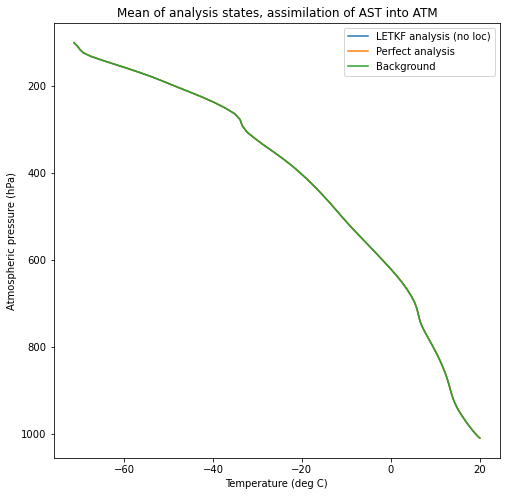

In [377]:
## Create subplots
fig, axs = plt.subplots(ncols=1, sharey=True, sharex=True) 

# Compute means
amean_avg = np.mean(analysis_means, axis=1)
perfa_avg = np.mean(perfect_analyses, axis=1)
bmean_avg = np.mean(background_means, axis=1)

# Plot means
axs.plot(amean_avg, atm_p[ind100hPa:], label='LETKF analysis (no loc)')
axs.plot(perfa_avg, atm_p[ind100hPa:], label='Perfect analysis')
axs.plot(bmean_avg, atm_p[ind100hPa:], label='Background')

# Legend
axs.legend()

# Set titles
axs.set_title('Mean of analysis states, assimilation of AST into ATM')

# Adjust and label axes
axs.invert_yaxis()
axs.set_ylabel('Atmospheric pressure (hPa)')
axs.set_xlabel('Temperature (deg C)')

plt.rcParams['figure.figsize'] = [8,8]
plt.savefig(plot_dir+'/metric_parts_mean_of_analysis_states')
plt.show()

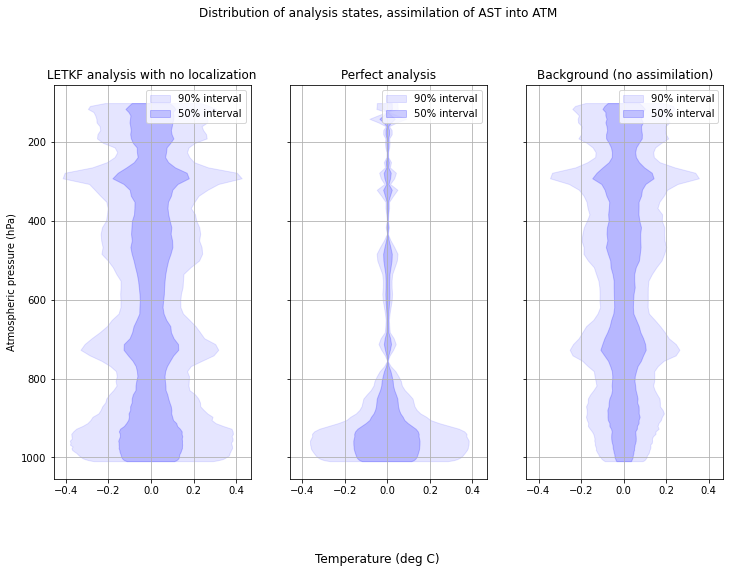

In [379]:
## Create subplots
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True) 

# Plot analysis mean (LETKF)
amean_avg = np.atleast_2d(np.mean(analysis_means, axis=1)).transpose()
amean_05 = np.percentile(analysis_means - amean_avg, 5, axis=1)
amean_95 = np.percentile(analysis_means - amean_avg, 95, axis=1)
amean_25 = np.percentile(analysis_means - amean_avg, 25, axis=1)
amean_75 = np.percentile(analysis_means - amean_avg, 75, axis=1)
#axs[0].plot(amean_avg, atm_p[ind100hPa:], label='Avg analysis mean')
axs[0].fill_betweenx(atm_p[ind100hPa:], amean_05, amean_95, color='b', alpha=.1, label='90% interval')
axs[0].fill_betweenx(atm_p[ind100hPa:], amean_25, amean_75, color='b', alpha=.2, label='50% interval')

# Plot analysis mean (perfect)
perfa_avg = np.atleast_2d(np.mean(perfect_analyses, axis=1)).transpose()
perfa_05 = np.percentile(perfect_analyses - perfa_avg, 5, axis=1)
perfa_95 = np.percentile(perfect_analyses - perfa_avg, 95, axis=1)
perfa_25 = np.percentile(perfect_analyses - perfa_avg, 25, axis=1)
perfa_75 = np.percentile(perfect_analyses - perfa_avg, 75, axis=1)
#axs[1].plot(perfa_avg, atm_p[ind100hPa:], label='Avg analysis mean')
axs[1].fill_betweenx(atm_p[ind100hPa:], perfa_05, perfa_95, color='b', alpha=.1, label='90% interval')
axs[1].fill_betweenx(atm_p[ind100hPa:], perfa_25, perfa_75, color='b', alpha=.2, label='50% interval')

# Plot analysis mean (no assimilation -- analaysis=background)
bmean_avg = np.atleast_2d(np.mean(background_means, axis=1)).transpose()
bmean_05 = np.percentile(background_means - bmean_avg, 5, axis=1)
bmean_95 = np.percentile(background_means - bmean_avg, 95, axis=1)
bmean_25 = np.percentile(background_means - bmean_avg, 25, axis=1)
bmean_75 = np.percentile(background_means - bmean_avg, 75, axis=1)
#axs[2].plot(bmean_avg, atm_p[ind100hPa:], label='Avg background mean')
axs[2].fill_betweenx(atm_p[ind100hPa:], bmean_05, bmean_95, color='b', alpha=.1, label='90% interval')
axs[2].fill_betweenx(atm_p[ind100hPa:], bmean_25, bmean_75, color='b', alpha=.2, label='50% interval')


# Legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set titles
fig.suptitle('Distribution of analysis states, assimilation of AST into ATM')
axs[0].set_title('LETKF analysis with no localization')
axs[1].set_title('Perfect analysis')
axs[2].set_title('Background (no assimilation)')

# Adjust and label axes
axs[0].invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Temperature (deg C)')

# Adjust aesthetics

plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)
plt.rcParams['figure.figsize'] = [12,8]

# Save and show
plt.savefig(plot_dir+'/metric_parts_dist_of_analysis_states')
plt.show()

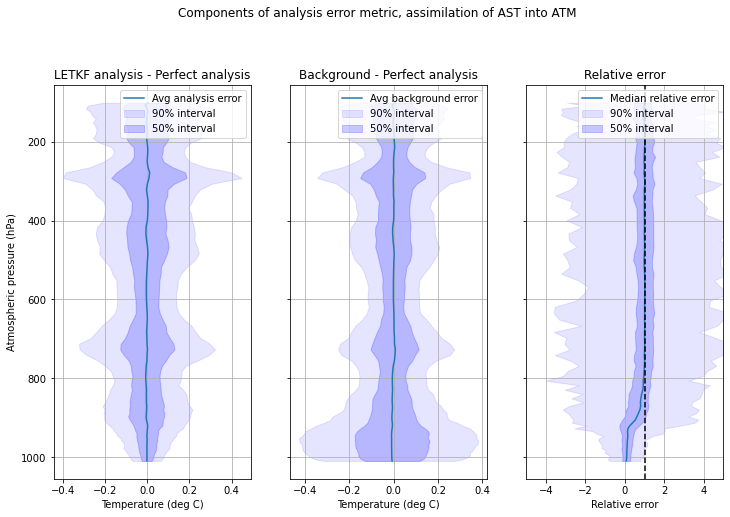

In [381]:
## Create subplots
fig, axs = plt.subplots(ncols=3, sharey=True) 

# Plot difference between analysis mean (LETKF) and perfect analysis
analysis_errs = analysis_means - perfect_analyses
adiff_avg = np.atleast_2d(np.mean(analysis_errs, axis=1)).transpose()
adiff_05 = np.percentile(analysis_errs, 5, axis=1)
adiff_95 = np.percentile(analysis_errs, 95, axis=1)
adiff_25 = np.percentile(analysis_errs, 25, axis=1)
adiff_75 = np.percentile(analysis_errs, 75, axis=1)
axs[0].plot(adiff_avg, atm_p[ind100hPa:], label='Avg analysis error')
axs[0].fill_betweenx(atm_p[ind100hPa:], adiff_05, adiff_95, color='b', alpha=.1, label='90% interval')
axs[0].fill_betweenx(atm_p[ind100hPa:], adiff_25, adiff_75, color='b', alpha=.2, label='50% interval')

# Plot difference between background mean and perfect analysis
background_errs = background_means - perfect_analyses
bdiff_avg = np.atleast_2d(np.mean(background_errs, axis=1)).transpose()
bdiff_05 = np.percentile(background_errs, 5, axis=1)
bdiff_95 = np.percentile(background_errs, 95, axis=1)
bdiff_25 = np.percentile(background_errs, 25, axis=1)
bdiff_75 = np.percentile(background_errs, 75, axis=1)
axs[1].plot(bdiff_avg, atm_p[ind100hPa:], label='Avg background error')
axs[1].fill_betweenx(atm_p[ind100hPa:], bdiff_05, bdiff_95, color='b', alpha=.1, label='90% interval')
axs[1].fill_betweenx(atm_p[ind100hPa:], bdiff_25, bdiff_75, color='b', alpha=.2, label='50% interval')

# Plot relative errors
relative_errs = np.divide(analysis_errs, background_errs)
rel_avg = np.atleast_2d(np.median(relative_errs, axis=1)).transpose()
rel_05 = np.percentile(relative_errs, 5, axis=1)
rel_95 = np.percentile(relative_errs, 95, axis=1)
rel_25 = np.percentile(relative_errs, 25, axis=1)
rel_75 = np.percentile(relative_errs, 75, axis=1)
axs[2].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
axs[2].axvline(x=1,color='k', linestyle='--')

axs[2].set_xlim([-5,5])

# Legend
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')

# Set titles
fig.suptitle('Components of analysis error metric, assimilation of AST into ATM')
axs[0].set_title('LETKF analysis - Perfect analysis')
axs[1].set_title('Background - Perfect analysis')
axs[2].set_title('Relative error')

# Adjust and label axes
axs[0].invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
axs[0].set_xlabel('Temperature (deg C)')
axs[1].set_xlabel('Temperature (deg C)')
axs[2].set_xlabel('Relative error')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)
plt.rcParams['figure.figsize'] = [12,8]

# Save and show
plt.savefig(plot_dir+'/metric_parts_components_of_relative_error')
plt.show()

### Plot metric for different localization radii with EnKF and LETKF

In [253]:
def create_distance_matrix(spatial_locations):
    N = len(spatial_locations) 
    # Create distance matrix
    dis = np.zeros((N,N))
    for jj in range(N):
        for ii in range(N):
            d = np.abs(spatial_locations[ii]-spatial_locations[jj])
            dis[ii, jj] = d
    return dis

In [446]:
def compute_relative_error(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate background mean and innovation
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    
    ## Compute perfect analysis
    perfect_innovation = y_ob - HofX @ this_avg
    kalman_gain = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    kf_increment = kalman_gain * perfect_innovation 
    perfect_analysis = this_avg + kf_increment
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    kf_increment = kf_increment[ind_state]
    perfect_analysis = perfect_analysis[ind_state, 0]
    pos_state = pos_state[ind_state]
    this_cov = this_cov[np.ix_(ind_state, ind_state)]
    HofX = HofX[:,ind_state] # will have to be more clever than this to deal with cross-fluid assimilation
    P_ens = P_ens[np.ix_(ind_state, ind_state)]
    num_levs = len(ind_state)
    
    ## Get distance matrix
    dist = create_distance_matrix(pos_state)
    
    ## Get relative error for each localization radius
    num_loc_rads =  len(loc_rads_state)
    relative_error_enkf = np.empty((num_levs, num_loc_rads))
    relative_error_letkf = np.empty((num_levs, num_loc_rads))
    norm_rel_error_enkf = np.empty(num_loc_rads)
    norm_rel_error_letkf = np.empty(num_loc_rads)
    for loc_ind in range(num_loc_rads):
        # Get localization radius
        localization_radius = loc_rads_state[loc_ind]
        # EnKF update
        if use_loc:
            loc = gaspari_cohn(dist/(localization_radius/2))
            C = loc * P_ens # Localize ensemble covariance (inefficient, but OK for a small system)
        else:
            C = P_ens 
        K = ( C @ HofX.transpose() )/( HofX @ C @ HofX.transpose() + R ) # Bad! But OK for single ob (scalar R)
        increment = K @ innovation
        analysis_mean_enkf = background_mean + increment[:,0]
        # LETKF update
        loc_rad_state = np.full_like(pos_state, localization_radius)
        analysis_mean_letkf = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
        # Compute relative error
        analysis_err_enkf = analysis_mean_enkf - perfect_analysis
        analysis_err_letkf = analysis_mean_letkf - perfect_analysis
        background_err = background_mean - perfect_analysis
        # Store relative error
        relative_error_enkf[:, loc_ind] = np.divide(analysis_err_enkf, background_err)
        relative_error_letkf[:, loc_ind] = np.divide(analysis_err_letkf, background_err)
        norm_rel_error_enkf[loc_ind] = np.sqrt(np.sum(np.square(analysis_err_enkf))) / np.sqrt(np.sum(np.square(background_err)))
        norm_rel_error_letkf[loc_ind] = np.sqrt(np.sum(np.square(analysis_err_letkf))) / np.sqrt(np.sum(np.square(background_err)))
    
    return relative_error_enkf, norm_rel_error_enkf, relative_error_letkf, norm_rel_error_letkf

In [424]:
def run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    relative_errors_enkf = np.empty((len(ind_state), len(loc_rads_state), num_trials))
    norm_rel_errors_enkf = np.empty((len(loc_rads_state), num_trials))
    relative_errors_letkf = np.empty((len(ind_state), len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(loc_rads_state), num_trials))
    for trial in range(num_trials):
        rerr_enkf, norm_rerr_enkf, rerr_letkf, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        relative_errors_enkf[:, :, trial] = rerr_enkf
        norm_rel_errors_enkf[:, trial] = norm_rerr_enkf
        relative_errors_letkf[:, :, trial] = rerr_enkf
        norm_rel_errors_letkf[:, trial] = norm_rerr_letkf
    return relative_errors_enkf, norm_rel_errors_enkf, relative_errors_letkf, norm_rel_errors_letkf

In [425]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rads_atm
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = True

In [449]:
relative_errors_enkf, norm_rel_errors_enkf, relative_errors_letkf, norm_rel_errors_letkf = run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:44: RuntimeWarning: invalid value encountered in reciprocal
  gc[less2] = 1/12*dist[less2]**5 - .5*dist[less2]**4 + 0.625*dist[less2]**3 + 5/3*dist[less2]**2 - 5*dist[less2] + 4 - 2/3*dist[less2]**-1 ;
/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


In [447]:
relative_errors_enkf_noloc, norm_rel_errors_enkf_noloc, relative_errors_letkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_rel_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=False)

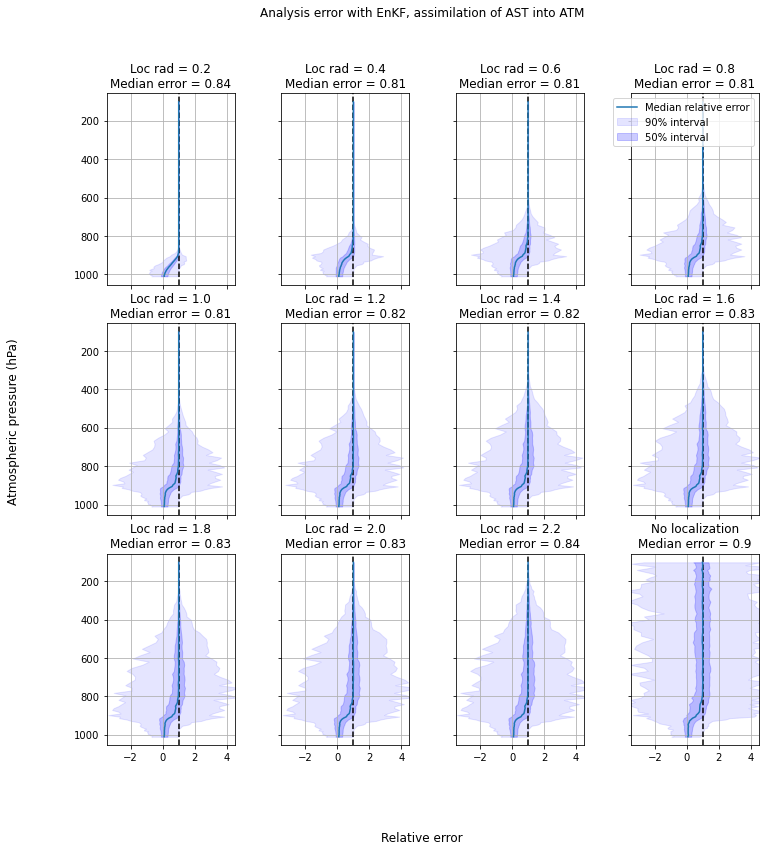

In [450]:
## Create subplots
fig, axs = plt.subplots(ncols=4, nrows=3, sharey=True, sharex=True) 

## Plot analysis errors with localization
for ind in range(len(loc_rads_state)):
    ax_col = ind % 4
    ax_row = int((ind - ax_col)/4)
    # Compute percentiles of relative error
    rerr = relative_errors_enkf[:, ind, :]
    rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
    rel_05 = np.percentile(rerr, 5, axis=1)
    rel_95 = np.percentile(rerr, 95, axis=1)
    rel_25 = np.percentile(rerr, 25, axis=1)
    rel_75 = np.percentile(rerr, 75, axis=1)
    # Plot relative errors
    axs[ax_row, ax_col].axvline(x=1,color='k', linestyle='--')
    axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
    # Set title and legend
    med_norm_rerr = np.round(np.median(norm_rel_errors_enkf[ind,:]), 2)
    axs[ax_row, ax_col].set_title('Loc rad = '+str(loc_rads_state[ind])+'\nMedian error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_enkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[2,3].axvline(x=1,color='k', linestyle='--')
axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_enkf_noloc[0,:]), 2)
axs[2,3].set_title('No localization\nMedian error = '+str(med_norm_rerr))

# Set titles
fig.suptitle('Analysis error with EnKF, assimilation of AST into ATM')
axs[0,3].legend(loc='upper right')

# Adjust and label axes
axs[0,0].set_xlim([-3.5,4.5])
axs[0,0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Relative error')

# Adjust aesthetics
#plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.5)
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad_enkf')
plt.show()

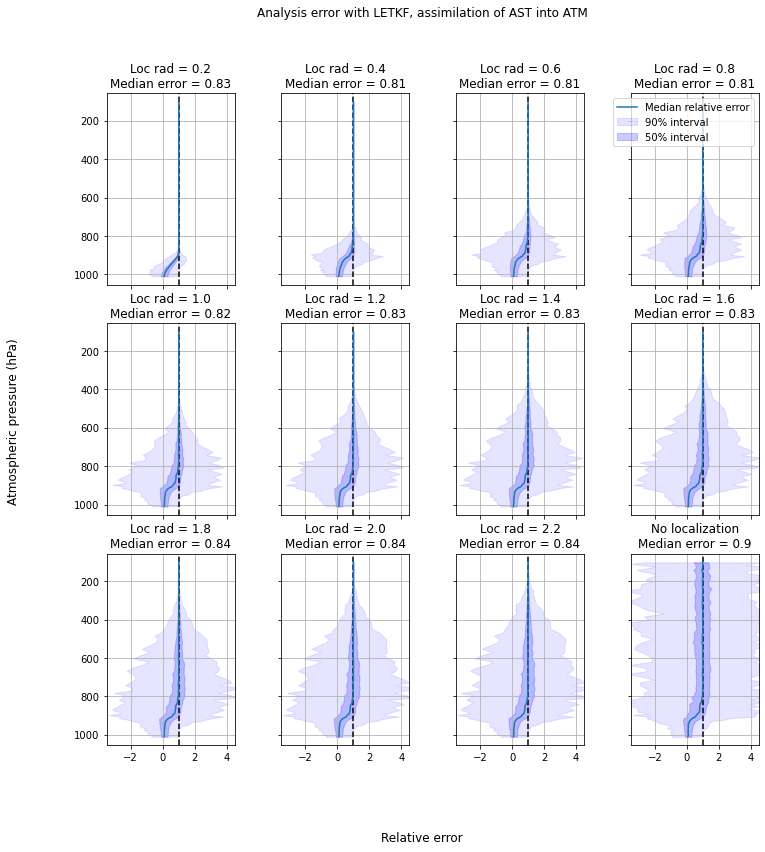

In [521]:
## Create subplots
fig, axs = plt.subplots(ncols=4, nrows=3, sharey=True, sharex=True) 

## Plot analysis errors with localization
for ind in range(len(loc_rads_state)):
    ax_col = ind % 4
    ax_row = int((ind - ax_col)/4)
    # Compute percentiles of relative error
    rerr = relative_errors_letkf[:, ind, :]
    rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
    rel_05 = np.percentile(rerr, 5, axis=1)
    rel_95 = np.percentile(rerr, 95, axis=1)
    rel_25 = np.percentile(rerr, 25, axis=1)
    rel_75 = np.percentile(rerr, 75, axis=1)
    # Plot relative errors
    axs[ax_row, ax_col].axvline(x=1,color='k', linestyle='--')
    axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
    # Set title and legend
    med_norm_rerr = np.round(np.median(norm_rel_errors_letkf[ind,:]), 2)
    axs[ax_row, ax_col].set_title('Loc rad = '+str(loc_rads_state[ind])+'\nMedian error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_letkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[2,3].axvline(x=1,color='k', linestyle='--')
axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf_noloc[0,:]), 2)
axs[2,3].set_title('No localization\nMedian error = '+str(med_norm_rerr))

# Set titles
fig.suptitle('Analysis error with LETKF, assimilation of AST into ATM')
axs[0,3].legend(loc='upper right')

# Adjust and label axes
axs[0,0].set_xlim([-3.5,4.5])
axs[0,0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Relative error')

# Adjust aesthetics
#plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.5)
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad_letkf')
plt.show()

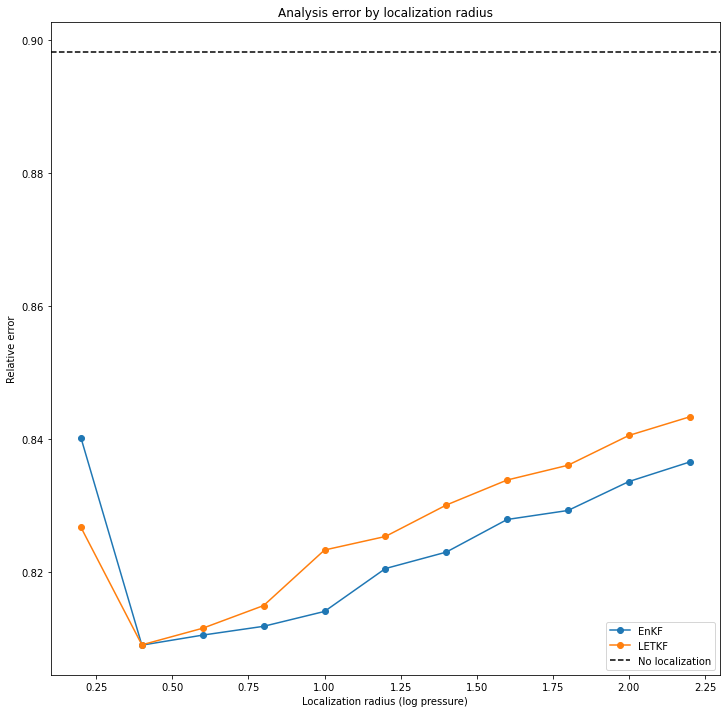

In [477]:
plt.plot(loc_rads_state, np.median(norm_rel_errors_enkf, axis=1), '-o', label='EnKF')
plt.plot(loc_rads_state, np.median(norm_rel_errors_letkf, axis=1), '-o', label='LETKF')
plt.axhline(y=np.median(norm_rel_errors_letkf_noloc), color='k', linestyle='--', label='No localization')
plt.legend()

# Adjust and label axes
plt.title('Analysis error by localization radius')
plt.ylabel('Relative error')
plt.xlabel('Localization radius (log pressure)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad')
plt.show()

### Compare DA update to 'perfect' background and 'truth'

In [490]:
def compute_relative_error_for_perfect_states(ind_state, ind_ob, this_avg, this_cov, this_cov_sqrt, ens_size = 20):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    x_ens = this_avg + x_err_ens
    
    ## Calculate background mean
    background_mean = np.mean(x_ens, 1)
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    
    ## Compute perfect analysis
    perfect_innovation = y_ob - HofX @ this_avg
    kalman_gain = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    kf_increment = kalman_gain * perfect_innovation 
    perfect_analysis = this_avg + kf_increment
    
    ## Take only state
    background_mean = background_mean[ind_state]
    perfect_analysis = perfect_analysis[ind_state, 0]
    this_avg = this_avg[ind_state, 0]
    xt = xt[ind_state, 0]
    
    # Compute relative error
    analysis_err_perfect_background = this_avg - perfect_analysis
    analysis_err_truth = xt - perfect_analysis
    background_err = background_mean - perfect_analysis
    # Store relative error
    relative_error_perfect_background = np.divide(analysis_err_perfect_background, background_err)
    relative_error_truth = np.divide(analysis_err_truth, background_err)
    norm_rel_error_perfect_background = np.sqrt(np.sum(np.square(analysis_err_perfect_background))) / np.sqrt(np.sum(np.square(background_err)))
    norm_rel_error_truth = np.sqrt(np.sum(np.square(analysis_err_truth))) / np.sqrt(np.sum(np.square(background_err)))
    
    return relative_error_perfect_background, norm_rel_error_perfect_background, relative_error_truth, norm_rel_error_truth

In [486]:
def run_multiple_trials_rel_err_for_perfect_states(ind_state, ind_ob, this_avg, this_cov, this_cov_sqrt, ens_size = 20, num_trials=100):
    relative_errors_perfect_background = np.empty((len(ind_state), num_trials))
    norm_rel_errors_perfect_background = np.empty(num_trials)
    relative_errors_truth = np.empty((len(ind_state), num_trials))
    norm_rel_errors_truth = np.empty(num_trials)
    for trial in range(num_trials):
        rerr_perfect_background, norm_rerr_perfect_background, rerr_truth, norm_rerr_truth = compute_relative_error_for_perfect_states(ind_state=ind_state, ind_ob=ind_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, ens_size=ens_size)
        relative_errors_perfect_background[:, trial] = rerr_perfect_background
        norm_rel_errors_perfect_background[trial] = norm_rerr_perfect_background
        relative_errors_truth[:,trial] = rerr_truth
        norm_rel_errors_truth[trial] = norm_rerr_truth
    return relative_errors_perfect_background, norm_rel_errors_perfect_background, relative_errors_truth, norm_rel_errors_truth

In [491]:
relative_errors_perfect_background, norm_rel_errors_perfect_background, relative_errors_truth, norm_rel_errors_truth = run_multiple_trials_rel_err_for_perfect_states(ind_state, ind_ob, this_avg, this_cov, this_cov_sqrt, num_trials=1000)

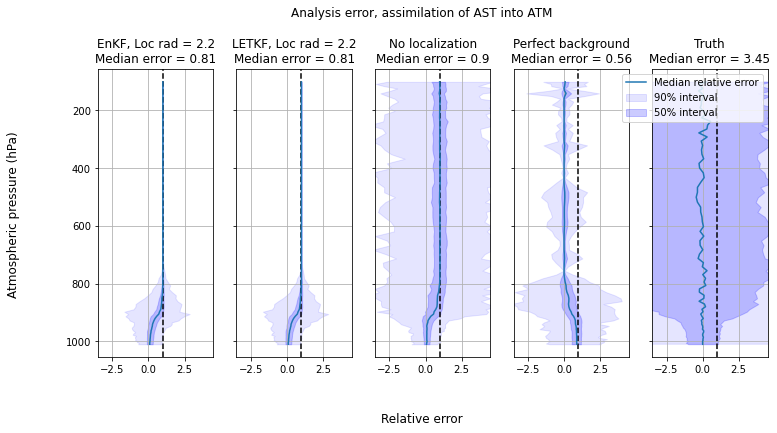

In [531]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

## Find best localization radius for EnKF and LETKF
ind_best_enkf = np.argmin(np.median(norm_rel_errors_enkf, axis=1))
ind_best_letkf = np.argmin(np.median(norm_rel_errors_letkf, axis=1))

## Plot Analysis Error for EnKF with best localization radius
# Compute percentiles of relative error
rerr = relative_errors_enkf[:, ind_best_enkf, :]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[0].axvline(x=1,color='k', linestyle='--')
axs[0].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[0].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[0].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_enkf[ind_best_enkf,:]), 2)
axs[0].set_title('EnKF, Loc rad = '+str(loc_rads_state[ind])+'\nMedian error = '+str(med_norm_rerr))

## Plot Analysis Error for LETKF with best localization radius
# Compute percentiles of relative error
rerr = relative_errors_letkf[:, ind_best_letkf, :]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[1].axvline(x=1,color='k', linestyle='--')
axs[1].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[1].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[1].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf[ind_best_letkf,:]), 2)
axs[1].set_title('LETKF, Loc rad = '+str(loc_rads_state[ind])+'\nMedian error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_letkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[2].axvline(x=1,color='k', linestyle='--')
axs[2].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf_noloc[0,:]), 2)
axs[2].set_title('No localization\nMedian error = '+str(med_norm_rerr))

## Plot analysis errors with perfect background
# Compute percentiles of relative error
rerr = relative_errors_perfect_background
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[3].axvline(x=1,color='k', linestyle='--')
axs[3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_perfect_background), 2)
axs[3].set_title('Perfect background\nMedian error = '+str(med_norm_rerr))

## Plot analysis errors with truth
# Compute percentiles of relative error
rerr = relative_errors_truth
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
axs[4].axvline(x=1,color='k', linestyle='--')
axs[4].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[4].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[4].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_truth), 2)
axs[4].set_title('Truth\nMedian error = '+str(med_norm_rerr))

# Set titles
fig.suptitle('Analysis error, assimilation of AST into ATM')
axs[4].legend(loc='upper right')

# Adjust and label axes
axs[0].set_xlim([-3.5,4.5])
axs[0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Relative error')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2.5)
plt.rcParams['figure.figsize'] = [12,6]

# Save and show
plt.savefig(plot_dir+'/relative_error_with_various_analysis_states')
plt.show()